In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import Session, QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from matplotlib import pyplot as plt
from datetime import datetime, timezone
import numpy as np
import os, csv

# API tokens for IBM Quantum Platform. Updated on 04-Dec-2024.

## Account Information

### KQC_Pharmcadd
### ibm-q-kqc / pharcadd / research OR ibm-q / open / main
token = 'e2b36571a4a8ed3720a30c8d7b2d59b55347beebe48614832e74a156a3669e6179d306b2ff3727f08ef95b99c1166add2a774e80fff85405abe38a0da1eb1c8c'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

### my account: ichi@kaist
### ibm-q-skku / kaist / kaist-graduate OR ibm-q / open / main
token = '23b4b9e4f3507d73dd25691b5b96bc6a70ab7798ea6821b91db525151323338264a62e5adfff61edb604f62fcaa51a4484a54450bb239b8c52e8d1ccd76344c2'

instances = [marrakesh, fez (156), torino (133), brussels, nazca, strasbourg, {kyiv, brisbane, sherbrooke} (127)]

Usage limits (open): Monthly usage is limited up to 10 minutes, refreshes on the first of each month. At most 3 pending workloads at a time.

## Load QiskitRuntimeService

In [2]:
# Show the list of the saved accounts
saved_accounts = QiskitRuntimeService.saved_accounts()

#for key, value in saved_accounts.items():
#    print(key, value)

In [3]:
# Load account and generate QiskitRuntimeService
default_account = saved_accounts['kqc_seungchan']
service = QiskitRuntimeService(channel=default_account['channel'],token=default_account['token'])

# Error verification

## conduct quantum experiments on ibm backend : error verification

In [4]:
### set instructions for experiments
backend = service.get_backend('ibm_strasbourg') #least_busy()
print(backend.name)

ibm_strasbourg


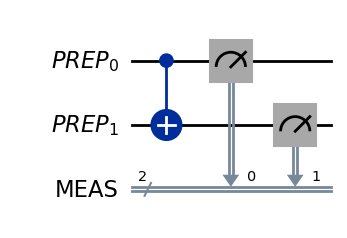

In [5]:
initial_layout = [62,61,72,63,60,81,64] # [24,23,25,34,22,26,43], [62,61,63,72,60,64,81]
shots_per_experiment = 8000
repetitions_to_get_stats = 10
num_targets = 5

### construct the quantum circuit for verifying error rates of SPAM and CNOT gate.
qr_sa = QuantumRegister(2, name='PREP')
cr_meas = ClassicalRegister(2, name='MEAS')
qc_veri = QuantumCircuit(qr_sa,cr_meas, name="VERIFIER")
qc_veri.cx(qr_sa[0],qr_sa[1])
qc_veri.measure(qr_sa,cr_meas)

qc_veri.draw('mpl')

In [6]:
### do experiments
backend_properties = backend.properties().to_dict()
datetime_experiment_veri = datetime.now(timezone.utc)

# OPEN TEXT FILE TO WRITE OUTPUTS FROM VERIFICATION #
path = "./data_output/{0}".format(datetime_experiment_veri.strftime('%Y%m%d'))
if not os.path.exists(path):
    os.makedirs(path)
    
f_veri = open('{0}/verification_outputs_{1}(UTC)_{2}.txt'.format(
    path, datetime_experiment_veri.strftime('%H%M'), backend.name), 'w', encoding='utf-8')

qubit_ctrl = initial_layout[0]
qubits_target = initial_layout[1:num_targets+1]

# DISPLAY GENERAL INFORMATION : backend_name, shots, reps #
print('==============================')
print("|     Experiment details     |")
print('------------------------------')
print('- date: {} (UTC)'.format(datetime_experiment_veri))
print('- backend: {}'.format(backend.name))
print('- # shots: {}'.format(shots_per_experiment))
print('- # repetitions: {}'.format(repetitions_to_get_stats))
print("-+ 'little-endian': qn ... q1 q0")
f_veri.write('====== Experiment details ======\n')
f_veri.write("- backend: {0}\n- # shots: {1}\n- # repetitions: {2}\n-+ 'little-endian': qn ... q1 q0\n".format(
    backend.name,shots_per_experiment,repetitions_to_get_stats))

counts_all_experiments = []
for target in qubits_target:
    # DISPLAY INFORMATION : system_qubit, anc_qubit #
    print('- system_ancilla: {0}->{1}'.format(qubit_ctrl,target))
    f_veri.write("system_ancilla: {0}->{1}\n".format(qubit_ctrl,target))
    
    # SET PASSMANAGER #
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[qubit_ctrl,target])
    isa_circuit = pm.run(qc_veri)
    with Session(backend=backend) as session:
        for rep in range(repetitions_to_get_stats):
            # RUN EXPERIMENT #
            sampler = Sampler(session=session)
            job = sampler.run([isa_circuit], shots=shots_per_experiment)
            
            # SAVE COUNTS #
            pub_results = job.result()[0]['__value__']['data']
            pub_counts = pub_results.MEAS.get_counts()
            if '00' not in pub_counts.keys():
                pub_counts['00'] = 0
            if '01' not in pub_counts.keys():
                pub_counts['01'] = 0
            if '10' not in pub_counts.keys():
                pub_counts['10'] = 0
            if '11' not in pub_counts.keys():
                pub_counts['11'] = 0
            counts_all_experiments.append(pub_counts)
            
            # DISPLAY RESULT : rep, counts(little-endian: qr[0] most right) #
            print("-+ ({0}-th) {1}".format(rep+1, pub_counts))
            f_veri.write("-+ ({0}-th) {1}\n".format(rep+1, pub_counts))

print('------------------------------')
print("|            Done            |")
print('==============================')
f_veri.write('==============================\n')

|     Experiment details     |
------------------------------
- date: 2024-12-13 01:39:45.285536+00:00 (UTC)
- backend: ibm_strasbourg
- # shots: 8000
- # repetitions: 10
-+ 'little-endian': qn ... q1 q0
- system_ancilla: 62->61


base_runtime_job._start_websocket_client:WARNING:2024-12-14 10:19:19,271: An error occurred while streaming results from the server for job cxds0wbgcckg008s4tag:
Traceback (most recent call last):
  File "C:\Users\SEOSEUNGCHAN\Anaconda3\envs\qiskitone\Lib\site-packages\qiskit_ibm_runtime\base_runtime_job.py", line 314, in _start_websocket_client
    self._ws_client.job_results()
  File "C:\Users\SEOSEUNGCHAN\Anaconda3\envs\qiskitone\Lib\site-packages\qiskit_ibm_runtime\api\clients\runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "C:\Users\SEOSEUNGCHAN\Anaconda3\envs\qiskitone\Lib\site-packages\qiskit_ibm_runtime\api\clients\base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "C:\\Users\\SEOSEUNGCHAN\\Anaconda3\\en

-+ (1-th) {'00': 5539, '10': 2166, '11': 96, '01': 199}
-+ (2-th) {'00': 5523, '10': 2157, '11': 113, '01': 207}
-+ (3-th) {'10': 2225, '00': 5474, '11': 117, '01': 184}
-+ (4-th) {'00': 5432, '10': 2224, '01': 212, '11': 132}
-+ (5-th) {'00': 5551, '10': 2158, '11': 102, '01': 189}
-+ (6-th) {'10': 2215, '00': 5525, '01': 166, '11': 94}
-+ (7-th) {'11': 97, '10': 2130, '00': 5569, '01': 204}
-+ (8-th) {'00': 5574, '10': 2134, '01': 210, '11': 82}
-+ (9-th) {'00': 5673, '10': 2052, '01': 183, '11': 92}
-+ (10-th) {'00': 5443, '10': 2259, '11': 97, '01': 201}
- system_ancilla: 62->72
-+ (1-th) {'10': 553, '00': 7119, '01': 245, '11': 83}
-+ (2-th) {'00': 7146, '11': 83, '10': 508, '01': 263}
-+ (3-th) {'00': 7129, '11': 88, '10': 558, '01': 225}
-+ (4-th) {'00': 7113, '10': 567, '01': 224, '11': 96}
-+ (5-th) {'00': 7135, '10': 558, '01': 219, '11': 88}
-+ (6-th) {'00': 7158, '10': 540, '11': 81, '01': 221}
-+ (7-th) {'00': 7126, '10': 528, '01': 250, '11': 96}
-+ (8-th) {'00': 7162, '0

31

### statistical analysis

In [7]:
avg_freqs_all_experiments = {} # averaged
stddevs_all_experiments = {}
# median_all_experiments = {}

for target in range(num_targets):
    avg_freqs_experiment = {'00':0,'01':0,'10':0,'11':0} # big-endian dictionary
    stddevs_experiment = {'00':0,'01':0,'10':0,'11':0} # big-endian dictionary
    for rep in range(repetitions_to_get_stats):
        for outcome in avg_freqs_experiment.keys():
                                                                    #┌> index_data                        #┌> little to big-endian
            avg_freqs_experiment[outcome] += counts_all_experiments[target*repetitions_to_get_stats + rep][outcome[-1::-1]] / shots_per_experiment
            stddevs_experiment[outcome] += (counts_all_experiments[target*repetitions_to_get_stats + rep][outcome[-1::-1]] / shots_per_experiment) ** 2

    for outcome in avg_freqs_experiment.keys():
        avg_freqs_experiment[outcome] /= repetitions_to_get_stats
        stddevs_experiment[outcome] /= repetitions_to_get_stats
        stddevs_experiment[outcome] -= avg_freqs_experiment[outcome] ** 2
        
    avg_freqs_all_experiments[qubits_target[target]] = avg_freqs_experiment
    stddevs_all_experiments[qubits_target[target]] = stddevs_experiment
        
print('==============================')
print("|         Statistics         |")
print('------------------------------')
print("- 'big-endian': q0 q1 ... qn") # IBM qn ... q1 q0 => q0 q1 ... qn
f_veri.write('======     Statistics     ======\n')
f_veri.write("- 'big-endian': q0 q1 ... qn\n")

for target in avg_freqs_all_experiments.keys():
    print('-+ system_ancilla: {0}->{1}'.format(qubit_ctrl,target))
    print('-++ Averaged frequency of {} repetitions:'.format(repetitions_to_get_stats))
    print('-+++ {}'.format(avg_freqs_all_experiments[target]))
    print('-++ Std. deviation:')
    print('-+++ {}'.format(stddevs_all_experiments[target]))
    f_veri.write('-+ system_ancilla: {0}->{1}\n-++ Averaged frequency of {2} repetitions:\n-+++ {3}\n-++ Std. deviation:\n-+++ {4}\n'.format(
        qubit_ctrl,target,repetitions_to_get_stats,avg_freqs_all_experiments[target],stddevs_all_experiments[target]))

print('------------------------------')
print("|            Done            |")
print('==============================')
f_veri.write('==============================\n')

|         Statistics         |
------------------------------
- 'big-endian': q0 q1 ... qn
-+ system_ancilla: 62->61
-++ Averaged frequency of 10 repetitions:
-+++ {'00': 0.6912875, '01': 0.27149999999999996, '10': 0.0244375, '11': 0.012775}
-++ Std. deviation:
-+++ {'00': 7.001578124987695e-05, '01': 5.155625000000108e-05, '10': 3.016406249999894e-06, '11': 2.961874999999974e-06}
-+ system_ancilla: 62->72
-++ Averaged frequency of 10 repetitions:
-+++ {'00': 0.8911124999999999, '01': 0.0684, '10': 0.0292375, '11': 0.011249999999999998}
-++ Std. deviation:
-+++ {'00': 6.65140625011329e-06, '01': 6.427500000000426e-06, '10': 3.4545312500000027e-06, '11': 6.187500000000659e-07}
-+ system_ancilla: 62->63
-++ Averaged frequency of 10 repetitions:
-+++ {'00': 0.9491250000000001, '01': 0.01465, '10': 0.030362499999999997, '11': 0.005862499999999999}
-++ Std. deviation:
-+++ {'00': 2.9593749997225416e-06, '01': 1.1806250000000358e-06, '10': 2.429531250000127e-06, '11': 5.576562500000221e-07}


31

### Backend Properties

In [8]:
print('==============================')
print("|      Calibration Data      |")
print('------------------------------')
f_veri.write('====== Calibration Data ======\n')

print("Backend name:", backend_properties['backend_name'])
print("Last calibrated date:", backend_properties['last_update_date'])
f_veri.write("Last calibrated date: {}\n".format(backend_properties['last_update_date']))

for qq in range(num_targets+1):
    rdout_err = backend_properties['qubits'][initial_layout[qq]][4]['value']
    id_err = backend_properties['gates'][initial_layout[qq]]['parameters'][0]['value']
    rz_err = backend_properties['gates'][initial_layout[qq]+127]['parameters'][0]['value']
    sx_err = backend_properties['gates'][initial_layout[qq]+127*2]['parameters'][0]['value']
    x_err = backend_properties['gates'][initial_layout[qq]+127*3]['parameters'][0]['value']
    
    print("========================================================================================")
    print("qubit {0} | readout_error (%): {1}".format(initial_layout[qq],rdout_err))
    print("qubit {0} | id_error (%): {1}".format(backend_properties['gates'][initial_layout[qq]]['qubits'][0], id_err))
    print("qubit {0} | rz_error (%): {1}".format(backend_properties['gates'][initial_layout[qq]+127]['qubits'][0], rz_err))
    print("qubit {0} | sx_error (%): {1}".format(backend_properties['gates'][initial_layout[qq]+127*2]['qubits'][0], sx_err))
    print("qubit {0} | x_error (%): {1}".format(backend_properties['gates'][initial_layout[qq]+127*3]['qubits'][0],x_err))
    
    f_veri.write("========================================================================================\n")
    f_veri.write("qubit {0} | readout_error (%): {1}\n".format(initial_layout[qq],rdout_err))
    f_veri.write("qubit {0} | id_error (%): {1}\n".format(backend_properties['gates'][initial_layout[qq]]['qubits'][0],id_err))
    f_veri.write("qubit {0} | rz_error (%): {1}\n".format(backend_properties['gates'][initial_layout[qq]+127]['qubits'][0],rz_err))
    f_veri.write("qubit {0} | sx_error (%): {1}\n".format(backend_properties['gates'][initial_layout[qq]+127*2]['qubits'][0],sx_err))
    f_veri.write("qubit {0} | x_error (%): {1}\n".format(backend_properties['gates'][initial_layout[qq]+127*3]['qubits'][0],x_err))
    
    if qq > 0:
        isdirect = False
        target = qubits_target[qq-1]
        for ecr_spec in backend_properties['gates'][127*4:]:
            if (qubit_ctrl in ecr_spec['qubits']) and (target in ecr_spec['qubits']):
                isdirect = True
                print("qubits {0} | ecr(cx?)_error (%): {1}".format([qubit_ctrl, target],ecr_spec['parameters'][0]['value']))
                f_veri.write("qubits {0} | ecr(cx?)_error (%): {1}\n".format([qubit_ctrl, target],ecr_spec['parameters'][0]['value']))
                
        if not isdirect:
            print("qubits [{0}, {1}] are not directly connected.".format(qubit_ctrl,target))
            f_veri.write("qubits [{0}, {1}] are not directly connected.\n".format(qubit_ctrl,target))
                
print('------------------------------')
print("|            Done            |")
print('==============================')
f_veri.write('==============================\n')

|      Calibration Data      |
------------------------------
Backend name: ibm_strasbourg
Last calibrated date: 2024-12-13 06:54:50+09:00
qubit 62 | readout_error (%): 0.05459999999999998
qubit 62 | id_error (%): 0.0002909637662819348
qubit 62 | rz_error (%): 0
qubit 62 | sx_error (%): 0.0002909637662819348
qubit 62 | x_error (%): 0.0002909637662819348
qubit 61 | readout_error (%): 0.10200000000000009
qubit 61 | id_error (%): 0.09932462381390536
qubit 61 | rz_error (%): 0
qubit 61 | sx_error (%): 0.09932462381390536
qubit 61 | x_error (%): 0.09932462381390536
qubits [62, 61] | ecr(cx?)_error (%): 0.06873478091269752
qubit 72 | readout_error (%): 0.09919999999999995
qubit 72 | id_error (%): 0.00017197669481745832
qubit 72 | rz_error (%): 0
qubit 72 | sx_error (%): 0.00017197669481745832
qubit 72 | x_error (%): 0.00017197669481745832
qubits [62, 72] | ecr(cx?)_error (%): 0.0074907288927867355
qubit 63 | readout_error (%): 0.020199999999999996
qubit 63 | id_error (%): 0.00019437642702307

31

### Solve equations to verify error rates

The probabilities from measurement experiments can be seen as functions of three error parameters $f,q$ and $\epsilon$. So, we can solve the series of equations for known probabilities $p(ij)$.

$$p(00) = (1-\epsilon)\left[f^2 (1-q)^2 + (1-f)^2 q^2 + f(1-f)(1-q)q  + (1-f)^2 q(1-q) + (1-f)fq^2\right] + \epsilon/4 $$
$$p(01) = (1-\epsilon)\left[f^2 (1-q)q + (1-f)^2 q^2 + f(1-f)(1-q)^2  + (1-f)^2 q^2 + (1-f)fq(1-q)\right] + \epsilon/4 $$
$$p(10) = (1-\epsilon)\left[f^2 q(1-q) + (1-f)^2 (1-q)q + f(1-f)q^2  + (1-f)^2 (1-q)^2 + (1-f)f(1-q)q\right] + \epsilon/4 $$
$$p(11) = (1-\epsilon)\left[f^2 q^2 + (1-f)^2 (1-q)^2 + f(1-f) q(1-q)  + (1-f)^2 (1-q)q + (1-f)f(1-q)^2\right] + \epsilon/4 $$

In [9]:
#    tuple = me.Func(args, nargout=)
import matlab.engine
# matlab_eng = matlab.engine.start_matlab()
# matlab_eng.quit()

print('==============================')
print("|   Verification of Errors   |")
print('------------------------------')
f_veri.write('=== Verification of Errors ===\n')

solved_fqe = {}
with matlab.engine.start_matlab() as me:
    subpath = me.genpath('./matlab')
    me.addpath(subpath, nargout=0)
    print('- Path is added: {}'.format(subpath))
    for target, freqs in avg_freqs_all_experiments.items():
        print(freqs)
        errors_fqe = me.solveProbabilities(freqs['00'],freqs['01'],freqs['10'],freqs['11'],nargout=1)
        solved_fqe[target] = me.abs(errors_fqe[0])
        solved_fqe[target][0][0] = 1-solved_fqe[target][0][0]
        print('- {0}->{1}: {2}'.format(qubit_ctrl,target,solved_fqe[target]))
        f_veri.write('- {0}->{1}: (f,q,e) = {2}\n'.format(qubit_ctrl,target,solved_fqe[target]))

print('------------------------------')
print("|            Done            |")
print('==============================')
f_veri.write('==============================\n')

# FILE:VERI... CLOSED #
f_veri.close()

|   Verification of Errors   |
------------------------------
- Path is added: ./matlab;
{'00': 0.6912875, '01': 0.27149999999999996, '10': 0.0244375, '11': 0.012775}
- 62->61: [[0.7330713340757897,0.2795289414280901,3.5030956821408306]]
{'00': 0.8911124999999999, '01': 0.0684, '10': 0.0292375, '11': 0.011249999999999998}
- 62->72: [[0.9573869046004105,0.062185468294785176,0.14734343680424605]]
{'00': 0.9491250000000001, '01': 0.01465, '10': 0.030362499999999997, '11': 0.005862499999999999}
- 62->63: [[0.9830602127206532,0.009473883133439855,0.0855178272954355]]
{'00': 0.6047625, '01': 0.36082499999999995, '10': 0.020775, '11': 0.0136375}
- 62->60: [[0.6348162269723792,0.37284881987067753,12.580280870221442]]
{'00': 0.7818125, '01': 0.012199999999999999, '10': 0.10511249999999998, '11': 0.100875}
- 62->81: [[0.8419922622299526,0.1508014115083341,0.6567138260026593]]
------------------------------
|            Done            |


# State Purification

In [10]:
def state_purifier(num_add, max_add):

    qr = QuantumRegister(1+max_add,name='SP_Puri')
    cr = ClassicalRegister(1+num_add,name='MEAS')
    qc = QuantumCircuit(qr,cr,name='PURIFIER')
    
    if (num_add>0):               # purification is applied
        for target in range(num_add): # anc = 1,...,n
            qc.cx(qr[0],qr[1+target])
    qc.barrier(qr)
    qc.measure(qr[:1+num_add],cr)
        
    return qc

def distiller(counts,num_add,ismonitor): # counts in little-endian
    test_dict = {}
    distilled_count = [0, 0] # [ #accepted states, #outcome'0' ]
    for outcome, count in counts.items():
        if (num_add==0) | ((num_add>0) & (outcome[:-1] == ('0'*num_add))): # outcomes of additional qubits are all zero.
            distilled_count[0] += count
            if outcome[-1] == '0':
                distilled_count[1] += count
            if ismonitor:
                test_dict[outcome] = count
    if ismonitor:
        print('distiller monitor: (',num_add,')',test_dict)
    return distilled_count

## conduct quantum experiments on ibm backend : state purification

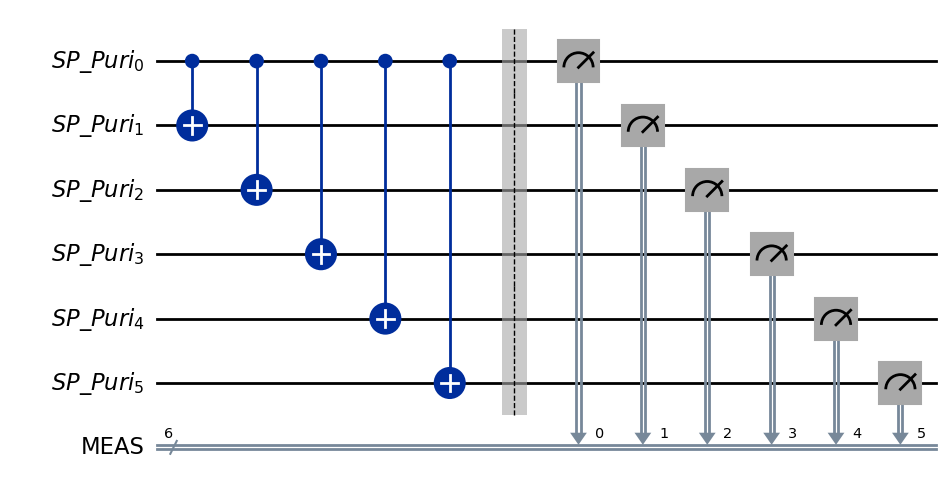

In [11]:
max_add = 5

# CONSTRUCT PURIFIER CIRCUITS #
sp_circuits = []
for num_add in range(max_add+1):
    purifier_size = 1+num_add
    qc_puri = state_purifier(num_add,max_add)
    sp_circuits.append(qc_puri)

# last quantum circuit # (12/11 added: 20:00)
qc_puri.draw('mpl')

In [12]:
datetime_experiment_puri = datetime.now(timezone.utc)
f_puri = open('{0}/purification_outputs_{1}(UTC)_{2}.txt'.format(
    path, datetime_experiment_puri.strftime('%H%M'), backend.name), 'w', encoding='utf-8')


# DISPLAY INFORMATION : backend_name, system_qubit, anc_qubit, shots, reps #
print('==============================')
print("|  Purification experiments  |")
print('------------------------------')
print('- date: {} (UTC)'.format(datetime_experiment_puri))
print('- backend: {}'.format(backend.name))
print('- system: {}'.format(initial_layout[0]))
print('- ancilla: {}'.format(initial_layout[1:max_add+1]))
print('- # shots: {}'.format(shots_per_experiment))
print('- # repetitions: {}'.format(repetitions_to_get_stats))
print("-+ 'little-endian': qn ... q1 q0")
f_puri.write('== Purification experiments ==\n')
f_puri.write("- backend: {0}\n- system: {1}\n- ancilla: {2}\n- # shots: {3}\n- # repetitions: {4}\n-+ 'little-endian': qn ... q1 q0\n".format(
    backend.name,initial_layout[0],initial_layout[1:max_add+1],shots_per_experiment,repetitions_to_get_stats))


# SET PASSMANAGER #
pm = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=initial_layout[:1+max_add])
isa_circuit = [pm.run(qc) for qc in sp_circuits]

counts_all_experiments = []
with Session(backend=backend) as session:
    for num_add in range(max_add+1):
        print("-+ number of additional qubits: {}".format(num_add))
        f_puri.write("-+ number of additional qubits: {}\n".format(num_add))
        for rep in range(repetitions_to_get_stats):
            # RUN EXPERIMENT #
            sampler = Sampler(session=session)
            job = sampler.run([isa_circuit[num_add]], shots = shots_per_experiment)

            # SAVE COUNTS #
            pub_results = job.result()[0]['__value__']['data']
            pub_counts = pub_results.MEAS.get_counts()

            bin_list = [bin(i)[2:] for i in range(2**(1+num_add))]
            bin_digit_padded_list = ['0'*(1+num_add-len(bn)) + bn for bn in bin_list]
            for outcome in bin_digit_padded_list:
                if outcome not in pub_counts.keys():
                    pub_counts[outcome] = 0
                    
            counts_all_experiments.append(pub_counts)

            # DISPLAY RESULT : rep, counts(little-endian: qr[0] most right) #
            print("-++ ({0}-th rep.) Done.".format(rep+1))
            f_puri.write("-++ ({0}-th rep.) counts: {1}\n".format(rep+1,pub_counts))

print('------------------------------')
print("|            Done            |")
print('==============================')
f_puri.write('==============================\n')

|  Purification experiments  |
------------------------------
- date: 2024-12-16 00:07:10.302780+00:00 (UTC)
- backend: ibm_strasbourg
- system: 62
- ancilla: [61, 72, 63, 60, 81]
- # shots: 8000
- # repetitions: 10
-+ 'little-endian': qn ... q1 q0
-+ number of additional qubits: 0
-++ (1-th rep.) Done.
-++ (2-th rep.) Done.
-++ (3-th rep.) Done.
-++ (4-th rep.) Done.
-++ (5-th rep.) Done.
-++ (6-th rep.) Done.
-++ (7-th rep.) Done.
-++ (8-th rep.) Done.
-++ (9-th rep.) Done.
-++ (10-th rep.) Done.
-+ number of additional qubits: 1
-++ (1-th rep.) Done.
-++ (2-th rep.) Done.
-++ (3-th rep.) Done.
-++ (4-th rep.) Done.
-++ (5-th rep.) Done.
-++ (6-th rep.) Done.
-++ (7-th rep.) Done.
-++ (8-th rep.) Done.
-++ (9-th rep.) Done.
-++ (10-th rep.) Done.
-+ number of additional qubits: 2
-++ (1-th rep.) Done.
-++ (2-th rep.) Done.
-++ (3-th rep.) Done.
-++ (4-th rep.) Done.
-++ (5-th rep.) Done.
-++ (6-th rep.) Done.
-++ (7-th rep.) Done.
-++ (8-th rep.) Done.
-++ (9-th rep.) Done.
-++ (10-t

31

### Purification (IBM)

|  Purification post-process  |
-------------------------------
- Results
------------------------------------------------------------------------------------------
n  | avg_prob_accepted    var_prob_accepted    avg_prob0_purified   var_prob0_purified  
------------------------------------------------------------------------------------------
0  | 1.00000000           0.00000000           0.96082500           0.00000297          
1  | 0.74560000           0.00004428           0.95670317           0.00000491          
2  | 0.47473750           0.00027415           0.96436682           0.00000495          
3  | 0.45628750           0.00344586           0.96570340           0.00000344          
4  | 0.06852500           0.00015132           0.97695683           0.00001938          
5  | 0.10556250           0.00011702           0.54313606           0.00222965          
------------------------------------------------------------------------------------------
- Plots


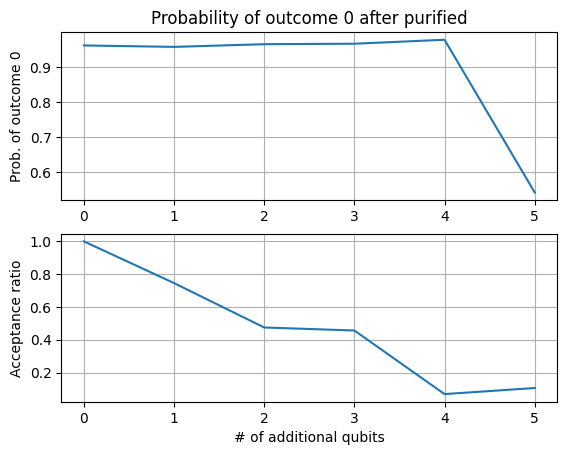

------------------------------
|            Done            |


31

In [15]:
distilled_data_all_ibm = {'#accepted':[],'#outcome0':[]}
probs_succ_all_ibm = {'mean':[],'variance':[]}
purified_fids_all_ibm = {'mean':[],'variance':[]}

print('===============================')
print("|  Purification post-process  |")
print('-------------------------------')
f_puri.write('== Purification post-process ==\n')

print('- Results')
print('-'*90)
print("n  | {0:<20} {1:<20} {2:<20} {3:<20}".format(
    'avg_prob_accepted','var_prob_accepted','avg_prob0_purified','var_prob0_purified'))
print('-'*90)
f_puri.write('- Results\n{0}\n n | {1:<20} {2:<20} {3:<20} {4:<20}\n{0}\n'.format(
    '-'*90,'avg_prob_accepted','var_prob_accepted','avg_prob0_purified','var_prob0_purified'))

for num_add in range(max_add+1):
    prob_succ = 0
    prob_succ_sq = 0
    fidelity = 0
    fidelity_sq = 0
    for rep in range(repetitions_to_get_stats):
        idx = num_add*repetitions_to_get_stats + rep
        distilled_data = distiller(counts_all_experiments[idx], num_add, False)
        distilled_data_all_ibm['#accepted'].append(distilled_data[0])
        distilled_data_all_ibm['#outcome0'].append(distilled_data[1])

        prob_succ += distilled_data[0] / shots_per_experiment
        prob_succ_sq += (distilled_data[0] / shots_per_experiment) ** 2
        fidelity += distilled_data[1] / distilled_data[0]
        fidelity_sq += (distilled_data[1] / distilled_data[0]) ** 2
        
    probs_succ_all_ibm['mean'].append(prob_succ / repetitions_to_get_stats)
    probs_succ_all_ibm['variance'].append(
        (prob_succ_sq / repetitions_to_get_stats) - ((prob_succ / repetitions_to_get_stats) ** 2))
    purified_fids_all_ibm['mean'].append(fidelity / repetitions_to_get_stats)
    purified_fids_all_ibm['variance'].append(
        (fidelity_sq / repetitions_to_get_stats) - ((fidelity / repetitions_to_get_stats) ** 2))

    print("{0:<3}| {1:<20.8f} {2:<20.8f} {3:<20.8f} {4:<20.8f}".format(
        num_add, probs_succ_all_ibm['mean'][-1], probs_succ_all_ibm['variance'][-1], 
        purified_fids_all_ibm['mean'][-1], purified_fids_all_ibm['variance'][-1]))
    f_puri.write("{0:>3}| {1:<20.8f} {2:<20.8f} {3:<20.8f} {4:<20.8f}\n".format(
        num_add, probs_succ_all_ibm['mean'][-1], probs_succ_all_ibm['variance'][-1], 
        purified_fids_all_ibm['mean'][-1], purified_fids_all_ibm['variance'][-1]))

print('-'*90)
f_puri.write('{}\n'.format('-'*90))

print('- Plots')
f_puri.write("- Plots were saved as PNG files.\n")

xaxis = np.array([n for n in range(max_add+1)])

fig_ibm = plt.figure('ibm')

plt.subplot(2,1,1)
plt.plot(xaxis, purified_fids_all_ibm['mean'])
plt.ylabel('Prob. of outcome 0')
plt.title('Probability of outcome 0 after purified')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(xaxis, probs_succ_all_ibm['mean'])
plt.xlabel('# of additional qubits')
plt.ylabel('Acceptance ratio')
plt.grid(True)

fig_ibm.savefig('{0}/purification_ibm_outputs_{1}(UTC)_{2}.png'.format(
    path, datetime_experiment_puri.strftime('%H%M'), backend.name))

plt.show()

print('------------------------------')
print("|            Done            |")
print('==============================')
f_puri.write('==============================\n')

### Purification (MATLAB)

|    Purification Simul.     |
------------------------------
- 62->61: [[0.7330713340757897,0.2795289414280901,3.5030956821408306]]
- 62->72: [[0.9573869046004105,0.062185468294785176,0.14734343680424605]]
- 62->63: [[0.9830602127206532,0.009473883133439855,0.0855178272954355]]
- 62->60: [[0.6348162269723792,0.37284881987067753,12.580280870221442]]
- 62->81: [[0.8419922622299526,0.1508014115083341,0.6567138260026593]]
- Path is added: ./matlab;
- target 61
-+ Purification condition check:
-++ critical error rate of CNOT (e_c): 0.26732143705325573
-++ verified error rate of CNOT (e_v): 3.5030956821408306
-+++ Cannot be purified! (e_c < e_v)
-+ Results
------------------------------------------------------------------------------------------
n  | avg_prob_accepted    avg_prob0_purified  
------------------------------------------------------------------------------------------
0  | 1.00000000           0.73307133          
1  | 0.22805244           -2.05818292         
2  | 1.36609481  

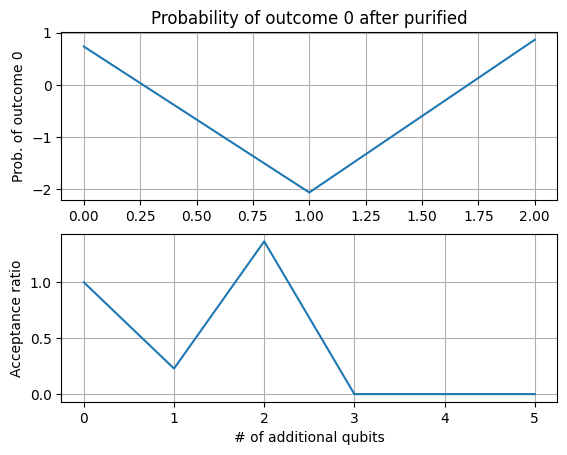

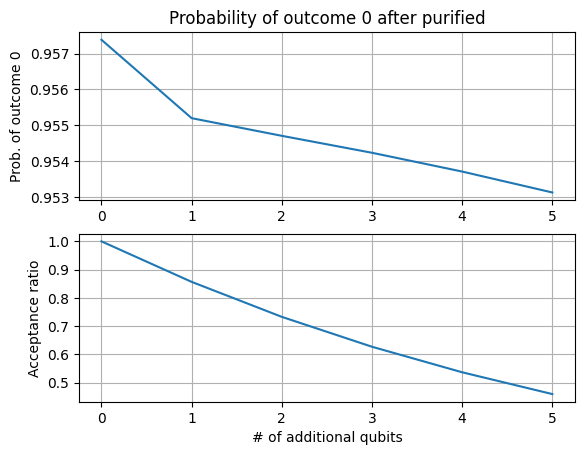

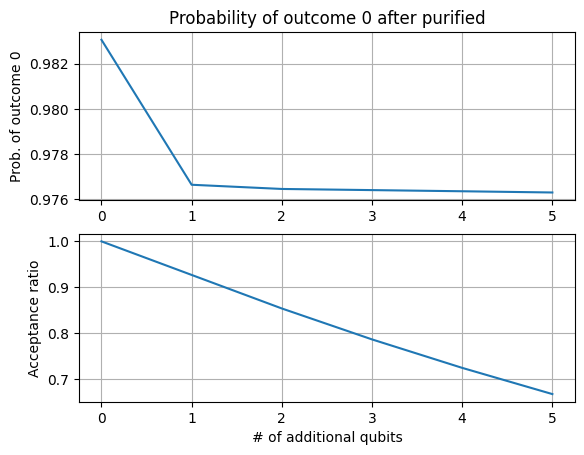

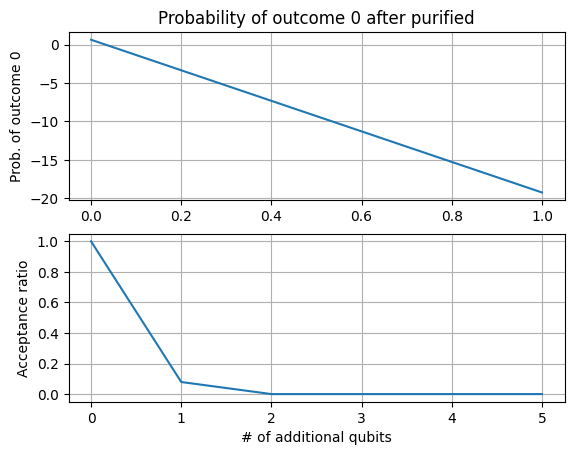

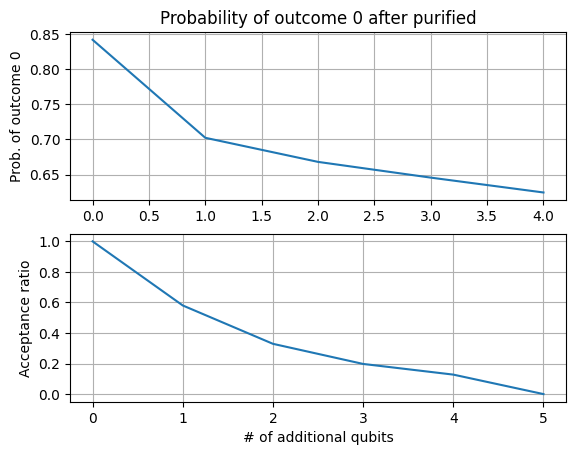

------------------------------
|            Done            |


In [16]:
plt.clf()

print('==============================')
print("|    Purification Simul.     |")
print('------------------------------')
f_puri.write('==== Purification Simul. ====\n')

xaxis = np.array([n for n in range(max_add+1)])

for target, fqe in solved_fqe.items():
    print('- {0}->{1}: {2}'.format(qubit_ctrl,target,fqe))
    f_puri.write('- {0}->{1}: (f,q,e) = {2}\n'.format(qubit_ctrl,target,fqe))

purified_fids_all_mat = {}
probs_succ_all_mat = {}
with matlab.engine.start_matlab() as me:
    subpath = me.genpath('./matlab')
    me.addpath(subpath, nargout=0)
    print('- Path is added: {}'.format(subpath))
    
    idx_fig_matlab = 0
    for target, fqe_cap in solved_fqe.items():
        print('- target {0}'.format(target))
        f_puri.write('- target {0}\n'.format(target))
        
        fqe = fqe_cap[0]
        #fqe[2] = 0.01 # to test if color is changed well
        
        # Check if purification is possible, CNOT error test #
        e_c = (8*(fqe[0]**3)-12*(fqe[0]**2)+4*fqe[0]) / (8*(fqe[0]**3)-12*(fqe[0]**2)+4*fqe[0]-1)
        if e_c < fqe[2]:
            color = '\033[31m'
            ispossible = 'not'
        else:
            color = '\033[34m'
            ispossible = ''
        print('{}-+ Purification condition check:'.format(color))
        print('-++ critical error rate of CNOT (e_c): {}'.format(e_c))
        print('-++ verified error rate of CNOT (e_v): {}'.format(fqe[2]))
        print('-+++ Can{} be purified! (e_c < e_v)\033[0m'.format(ispossible))
        f_puri.write('-+ Purification condition check:\n-++ critical error rate of CNOT (e_c): {0}\n-++ verified error rate of CNOT (e_v): {1}\n-+++ Can{2} be purified! (e_c < e_v)\n'.format(
            e_c,fqe[2],ispossible))
        
        fouts = me.state_purify_py(fqe[0], fqe[1], fqe[2], max_add, nargout=2)
        purified_fids_all_mat[target] = np.array(fouts[0][0])
        probs_succ_all_mat[target] = np.array(fouts[1][0])
#        print('-++ prob0_purified: {0}'.format(purified_fids_all_mat[target][0]))
#        print('-++ prob_accepted: {0}'.format(probs_succ_all_mat[target][0]))

        print('-+ Results')
        print('-'*90)
        print("n  | {0:<20} {1:<20}".format('avg_prob_accepted','avg_prob0_purified'))
        print('-'*90)
        f_puri.write('-+ Results\n{0}\n n | {1:<20} {2:<20}\n{0}\n'.format('-'*90,'avg_prob_accepted','avg_prob0_purified'))
        for num_add in range(max_add+1):
            print("{0:<3}| {1:<20.8f} {2:<20.8f}".format(
                num_add, probs_succ_all_mat[target][0][num_add], purified_fids_all_mat[target][0][num_add]))
            f_puri.write("{0:<3}| {1:<20.8f} {2:<20.8f}\n".format(
                num_add, probs_succ_all_mat[target][0][num_add], purified_fids_all_mat[target][0][num_add]))          
        
        print('-'*90)
        f_puri.write('{}\n'.format('-'*90))
        
        idx_fig_matlab += 1
        fig_matlab = plt.figure(idx_fig_matlab)
        plt.subplot(2,1,1)
        plt.plot(xaxis, purified_fids_all_mat[target].reshape(max_add+1))
        plt.ylabel('Prob. of outcome 0')
        plt.title('Probability of outcome 0 after purified')
        plt.grid(True)

        plt.subplot(2,1,2)
        plt.plot(xaxis, probs_succ_all_mat[target].reshape(max_add+1))
        plt.xlabel('# of additional qubits')
        plt.ylabel('Acceptance ratio')
        plt.grid(True)

        fig_matlab.savefig('{0}/purification_matlab_outputs_{1}(UTC)_{2}_target{3}.png'.format(
            path, datetime_experiment_puri.strftime('%H%M'), backend.name, target))

    print('- Plots')
    f_puri.write("- Plots were saved as PNG files.\n")

    plt.show()

print('------------------------------')
print("|            Done            |")
print('==============================')
f_puri.write('==============================\n')

# FILE:PURI... CLOSED #
f_puri.close()